# Sorting OH from HI with WISE band W1+W2

## Imports + Basic Functions

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle as pkl
import pandas as pd
from pandas import DataFrame
from tabulate import tabulate
import time
import seaborn as sns
from tqdm import tqdm_notebook, trange

In [2]:
import astropy
import astropy.units as u
import astropy.constants as const
from astropy.table import Table as t
from astropy.table import vstack

from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

In [3]:
fOH = 1667.35903 * u.MHz          # OH rest frequency
fHI = 1420.40575 * u.MHz          # HI rest frequency

def zHI_to_zOH(zHI):
    return (fOH/fHI)*(1+zHI)-1

def zOH_to_zHI(zOH):
    return (fHI/fOH)*(1+zOH)-1

In [4]:
#plotting styles
paper = lambda: sns.set(context='paper', font_scale=1.2, style='ticks', palette = 'Set1', 
                        rc={'figure.figsize':(4,3), 'xtick.bottom': True, 'ytick.left':True, 'figure.dpi':200, 'figure.facecolor':'w',
                            'errorbar.capsize': 2, 'xtick.direction': 'in', 'ytick.direction': 'in'})

In [5]:
paper()

## Machine Learning Functions

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

In [9]:
def preliminary_model_tests(X, y, return_OH_recall=False, print_table=True):
    # split data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    # scale it
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test) 
    
    # creating a table to print out at the end
    table_print = []
    
    clf = DecisionTreeClassifier().fit(X_train, y_train)
    clf_pred = clf.predict(X_test)
    clf_OH_r = classification_report(y_test, clf_pred, output_dict = True)['OH']['recall']
    clf_OH_f1 = classification_report(y_test, clf_pred, output_dict = True)['OH']['f1-score']
    clf_HI_f1 = classification_report(y_test, clf_pred, output_dict = True)['HI']['f1-score']
    table_print.append(['Decision Tree', clf_HI_f1, clf_OH_f1, clf_OH_r])
    
    knn = KNeighborsClassifier().fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    knn_OH_r = classification_report(y_test, knn_pred, output_dict = True)['OH']['recall']
    knn_OH_f1 = classification_report(y_test, knn_pred, output_dict = True)['OH']['f1-score']
    knn_HI_f1 = classification_report(y_test, knn_pred, output_dict = True)['HI']['f1-score']
    table_print.append(['K-Neighbors', knn_HI_f1, knn_OH_f1, knn_OH_r])
    
    lda = LinearDiscriminantAnalysis().fit(X_train, y_train)
    lda_pred = lda.predict(X_test)
    lda_OH_r = classification_report(y_test, lda_pred, output_dict = True)['OH']['recall']
    lda_OH_f1 = classification_report(y_test, lda_pred, output_dict = True)['OH']['f1-score']
    lda_HI_f1 = classification_report(y_test, lda_pred, output_dict = True)['HI']['f1-score']
    table_print.append(['Linear Discriminant', lda_HI_f1, lda_OH_f1, lda_OH_r])
    
    qda = QuadraticDiscriminantAnalysis().fit(X_train, y_train)
    qda_pred = qda.predict(X_test)
    qda_OH_r = classification_report(y_test, qda_pred, output_dict = True)['OH']['recall']
    qda_OH_f1 = classification_report(y_test, qda_pred, output_dict = True)['OH']['f1-score']
    qda_HI_f1 = classification_report(y_test, qda_pred, output_dict = True)['HI']['f1-score']
    table_print.append(['Quadratic Discriminant', qda_HI_f1, qda_OH_f1, qda_OH_r])
    
    gnb = GaussianNB().fit(X_train, y_train)
    gnb_pred = gnb.predict(X_test)
    gnb_OH_r = classification_report(y_test, gnb_pred, output_dict = True)['OH']['recall']
    gnb_OH_f1 = classification_report(y_test, gnb_pred, output_dict = True)['OH']['f1-score']
    gnb_HI_f1 = classification_report(y_test, gnb_pred, output_dict = True)['HI']['f1-score']
    table_print.append(['Gaussian Naive Bayes', gnb_HI_f1, gnb_OH_f1, gnb_OH_r])
    
    svm = SVC().fit(X_train, y_train)
    svm_pred = svm.predict(X_test)
    svm_OH_r = classification_report(y_test, svm_pred, output_dict = True)['OH']['recall']
    svm_OH_f1 = classification_report(y_test, svm_pred, output_dict = True)['OH']['f1-score']
    svm_HI_f1 = classification_report(y_test, svm_pred, output_dict = True)['HI']['f1-score']
    table_print.append(['Support Vector Machine', svm_HI_f1, svm_OH_f1, svm_OH_r])
    
    mlp = MLPClassifier().fit(X_train, y_train)
    mlp_pred = mlp.predict(X_test)
    mlp_OH_r = classification_report(y_test, mlp_pred, output_dict = True)['OH']['recall']
    mlp_OH_f1 = classification_report(y_test, mlp_pred, output_dict = True)['OH']['f1-score']
    mlp_HI_f1 = classification_report(y_test, mlp_pred, output_dict = True)['HI']['f1-score']
    table_print.append(['Neural Network', mlp_HI_f1, mlp_OH_f1, mlp_OH_r])
    
    table_print = np.array(table_print)
    
    if print_table:
        print(tabulate(table_print, headers=['Model', 'HI F1', 'OH F1', 'OH Recall'], tablefmt='orgtbl'))
    
    if return_OH_recall:
        return table_print[:,2]
    
    return

In [10]:
from itertools import compress, product

def combinations(items):
    return list(set(compress(items,mask)) for mask in product(*[[0,1]]*len(items)))[1:]

def find_best_optimization(data, all_features_names):
    fn_combinations = combinations(all_features_names)
    optimize_recall = np.zeros((7, len(fn_combinations)))
    y = data['classification']

    for i in trange(len(fn_combinations), desc = 'Combinations'):
        X = data[fn_combinations[i]]
        optimize_recall[:,i] = preliminary_model_tests(X, y, return_OH_recall=True, print_table=False)
    
    best = np.argmax(optimize_recall,axis=0)
    
    models = ['Decision Tree', 'K-Neighbors', 'LDA', 'QDA', 'GNB', 'SVM', 'Neural Nets']
    best_recalls = []
    best_model = []
    
    for i in range(len(best)):
        mx = optimize_recall[:,i][best[i]]
        best_recalls.append(mx)
        best_model.append(models[best[i]])
        
    optimize_table = t(rows = optimize_recall, names = fn_combinations)
    optimize_table['Model'] = models
    
    print('Best OH Recall:', np.max(best_recalls))
    print('Feature Name Combo:', fn_combinations[np.argmax(best_recalls)])
    print('Model:', best_model[np.argmax(best_recalls)])
    
    return optimize_table

## Import Data + Prepare It 

In [11]:
def ab_to_vega(mags):
    '''
    Converts WISE AB magnitudes to Vega Magnitudes
    '''
    dm1 = 2.699
    dm2 = 3.339
    dm3 = 5.174
    dm4 = 6.620
    
    mv1 = mags[0] - dm1
    mv2 = mags[1] - dm2
    mv3 = mags[2] - dm3
    mv4 = mags[3] - dm4
    
    return np.array((mv1, mv2, mv3, mv4))

In [12]:
WISE_OH_evolution = pkl.load(open("Data/Redshift_Evolutions/WISE_z_evolution_vega.pkl", "rb" ))
WISE_HI_evolution = pkl.load(open("Data/Redshift_Evolutions/HI_WISE_z_evolution_vega.pkl", "rb"))

In [13]:
# NGC 7674 is a problem.
del WISE_HI_evolution[53]

In [14]:
OH_zs = []
OH_1s = []
OH_2s = []
OH_3s = []
OH_4s = []

for key in [*WISE_OH_evolution]:
    OH_zs.extend(zOH_to_zHI(WISE_OH_evolution[key]['z']))
    OH_1s.extend(WISE_OH_evolution[key]['W1'])
    OH_2s.extend(WISE_OH_evolution[key]['W2'])
    OH_3s.extend(WISE_OH_evolution[key]['W3'])
    OH_4s.extend(WISE_OH_evolution[key]['W4'])
    
OH_cs = ['OH']*len(OH_zs)
OH_WISE_data_badzs = t([OH_zs, OH_1s, OH_2s, OH_3s, OH_4s, OH_cs], 
                 names = ('z_HI', 'W1', 'W2', 'W3', 'W4', 'classification'))

nonsense_zHI = OH_WISE_data_badzs['z_HI'] < 0.0
OH_WISE_data = OH_WISE_data_badzs[~nonsense_zHI]
# OH_WISE_data.write('ML/OH_z_evolution.fits')

In [15]:
HI_zs = []
HI_1s = []
HI_2s = []
HI_3s = []
HI_4s = []

for key in [*WISE_HI_evolution]:
    HI_zs.extend(WISE_HI_evolution[key]['redshifts'])
    HI_1s.extend(WISE_HI_evolution[key]['W1mags'])
    HI_2s.extend(WISE_HI_evolution[key]['W2mags'])
    HI_3s.extend(WISE_HI_evolution[key]['W3mags'])
    HI_4s.extend(WISE_HI_evolution[key]['W4mags'])
    
HI_cs = ['HI']*len(HI_zs)
HI_WISE_data = t([HI_zs, HI_1s, HI_2s, HI_3s, HI_4s, HI_cs], 
                 names = ('z_HI', 'W1', 'W2', 'W3', 'W4', 'classification'))

In [16]:
all_WISE_data = vstack([OH_WISE_data, HI_WISE_data])
all_WISE_data['W1-W2'] = all_WISE_data['W1']-all_WISE_data['W2']
all_WISE_data['W2-W3'] = all_WISE_data['W2']-all_WISE_data['W3']

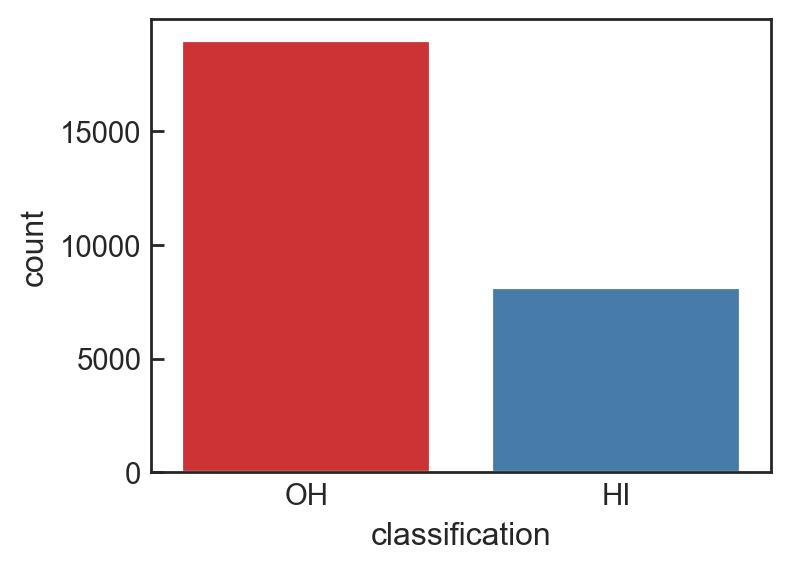

In [17]:
plt.figure()
sns.countplot(all_WISE_data['classification'],label="Count")
plt.show()

In [18]:
W1W2_cutoff = (all_WISE_data['W1'] <= (16.85 + 0.952*all_WISE_data['W1-W2']))
is_OH = (all_WISE_data['classification'] == 'OH')
is_HI = (all_WISE_data['classification'] == 'HI')

In [19]:
OH_HI_cols = ['#A9CCE3', '#A9AFE3', '#1A5276', '#504188']

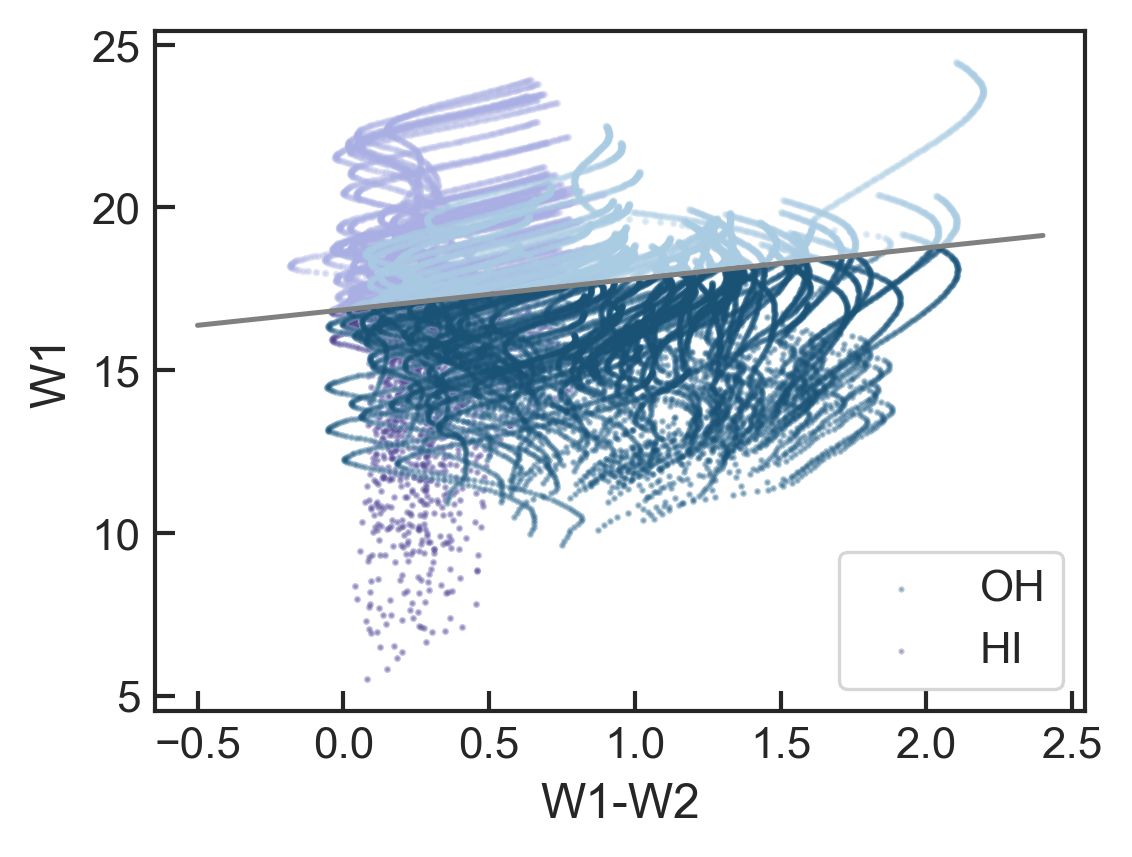

In [20]:
xs = np.arange(-0.5,2.5,0.1)
plt.figure(dpi=300)
plt.scatter(all_WISE_data['W1-W2'][is_OH], all_WISE_data['W1'][is_OH], s = 1, alpha = 0.3, color = OH_HI_cols[0], label = '', zorder = 10)
plt.scatter(all_WISE_data['W1-W2'][is_HI], all_WISE_data['W1'][is_HI], s = 1, alpha = 0.3, color = OH_HI_cols[1], label = '')
plt.scatter(all_WISE_data['W1-W2'][W1W2_cutoff & is_OH], all_WISE_data['W1'][W1W2_cutoff & is_OH], s = 2, alpha = 0.3, color = OH_HI_cols[2], label = 'OH', zorder = 10, marker = '.')
plt.scatter(all_WISE_data['W1-W2'][W1W2_cutoff & is_HI], all_WISE_data['W1'][W1W2_cutoff & is_HI], s = 2, alpha = 0.3, color = OH_HI_cols[3], label = 'HI', marker = '.')
plt.plot(xs, 16.85+0.952*xs, color = 'grey', zorder = 50)
plt.xlabel('W1-W2')
plt.ylabel('W1')
plt.legend()
plt.show()

In [21]:
all_WISE_data['z_HI'] = np.round(all_WISE_data['z_HI'],2)
all_WISE_df = DataFrame(np.array(all_WISE_data))
WISE_12_df = DataFrame(np.array(all_WISE_data[W1W2_cutoff]))

In [22]:
WISE_12_HI = DataFrame(np.array(all_WISE_data[W1W2_cutoff & is_HI]))
WISE_12_OH = all_WISE_data[W1W2_cutoff & is_OH]
numHI = len(WISE_12_HI)

rand_is = np.random.choice(range(len(WISE_12_OH)), numHI, replace = False)

WISE_12_OH_sample = DataFrame(np.array(WISE_12_OH[rand_is]))

WISE_12_df = pd.concat([WISE_12_HI, WISE_12_OH_sample], axis=0)

## Machine Learning

### Intial Tests

Start feeling out what works and what doesn't

In [26]:
feature_names = ['W1', 'W1-W2', 'z_HI']
X = WISE_12_df[feature_names]
y = WISE_12_df['classification']
preliminary_model_tests(X,y)

| Model                  |    HI F1 |    OH F1 |   OH Recall |
|------------------------+----------+----------+-------------|
| Decision Tree          | 0.801287 | 0.963639 |    0.972371 |
| K-Neighbors            | 0.868999 | 0.976348 |    0.987225 |
| Linear Discriminant    | 0.290288 | 0.906325 |    0.955734 |
| Quadratic Discriminant | 0.538978 | 0.895235 |    0.870766 |
| Gaussian Naive Bayes   | 0.519427 | 0.892678 |    0.871064 |
| Support Vector Machine | 0.520697 | 0.938185 |    0.991979 |
| Neural Network         | 0.619638 | 0.942894 |    0.97861  |


### Preparing Data

In [26]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['HI', 'OH'])
y = le.transform(y)

In [24]:
feature_names = ['W1', 'W1-W2', 'z_HI']
X = WISE_12_df[feature_names]
y = WISE_12_df['classification']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 15)

# scale it
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test) 

#### Playing with Model Parameters

In [ ]:
from tqdm import tqdm_notebook, trange

In [28]:
ps = np.array([1,1.5,2,2.5,3])

ns = np.array([ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 23, 32, 45, 62, 85, 
               117, 161, 221, 303, 417, 573, 788, 1082, 1487, 2043, 2807])

In [29]:
recalls_w12z = np.zeros([len(ns),len(ps)])

for i in trange(len(ns)):
    for j in range(len(ps)):
        n = ns[i]
        p = ps[j]
        knn = KNeighborsClassifier(n_neighbors=n, p=p, weights = 'distance')
        knn.fit(X_train, y_train)
        pred = knn.predict(X_test)

        recalls_w12z[i,j] = classification_report(y_test, pred, output_dict = True)['OH']['recall']

recalls_w12z = DataFrame(recalls_w12z, index = ns, columns = ps)


100%|██████████| 36/36 [00:26<00:00,  1.36it/s]


In [30]:
recalls_uniform_w12z = np.zeros([len(ns),len(ps)])

for i in trange(len(ns)):
    for j in range(len(ps)):
        n = ns[i]
        p = ps[j]
        knn = KNeighborsClassifier(n_neighbors=n, p=p, weights = 'uniform')
        knn.fit(X_train, y_train)
        pred = knn.predict(X_test)

        recalls_uniform_w12z[i,j] = classification_report(y_test, pred, output_dict = True)['OH']['recall']
        
recalls_uniform_w12z = DataFrame(recalls_uniform_w12z, index = ns, columns = ps)


100%|██████████| 36/36 [00:29<00:00,  1.22it/s]


In [31]:
recalls_w12z.to_pickle('Data/ML/recalls_testing_w12z_downsampled')
recalls_uniform_w12z.to_pickle('Data/ML/recalls_uniform_testing_w12z_downsampled')

In [32]:
recalls_w12z = pd.read_pickle('Data/ML/recalls_testing_w12z_downsampled')
recalls_uniform_w12z = pd.read_pickle('Data/ML/recalls_uniform_testing_w12z_downsampled')

Text(51.16666666666666, 0.5, 'Neighbors (k)')

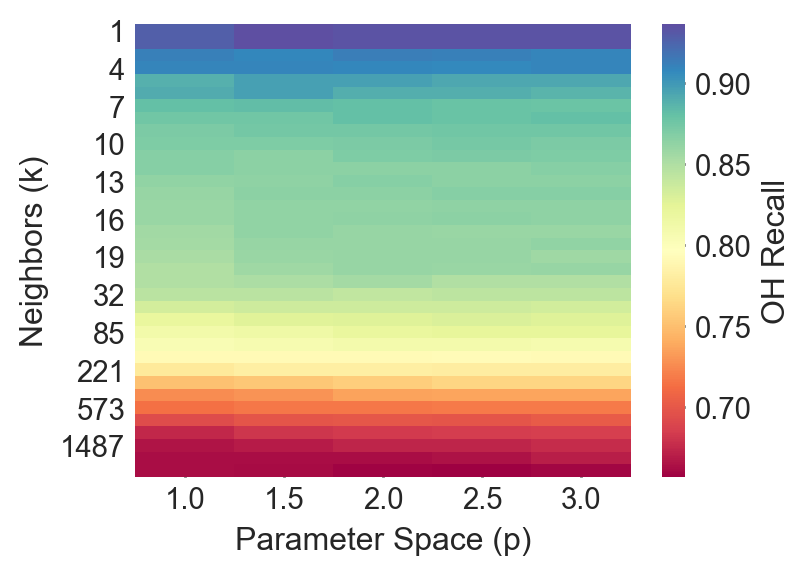

In [33]:
plt.figure(figsize=(4,3))
sns.heatmap(recalls_w12z, cmap = 'Spectral', cbar_kws={'label': 'OH Recall'})
plt.xlabel('Parameter Space (p)')
plt.ylabel('Neighbors (k)')

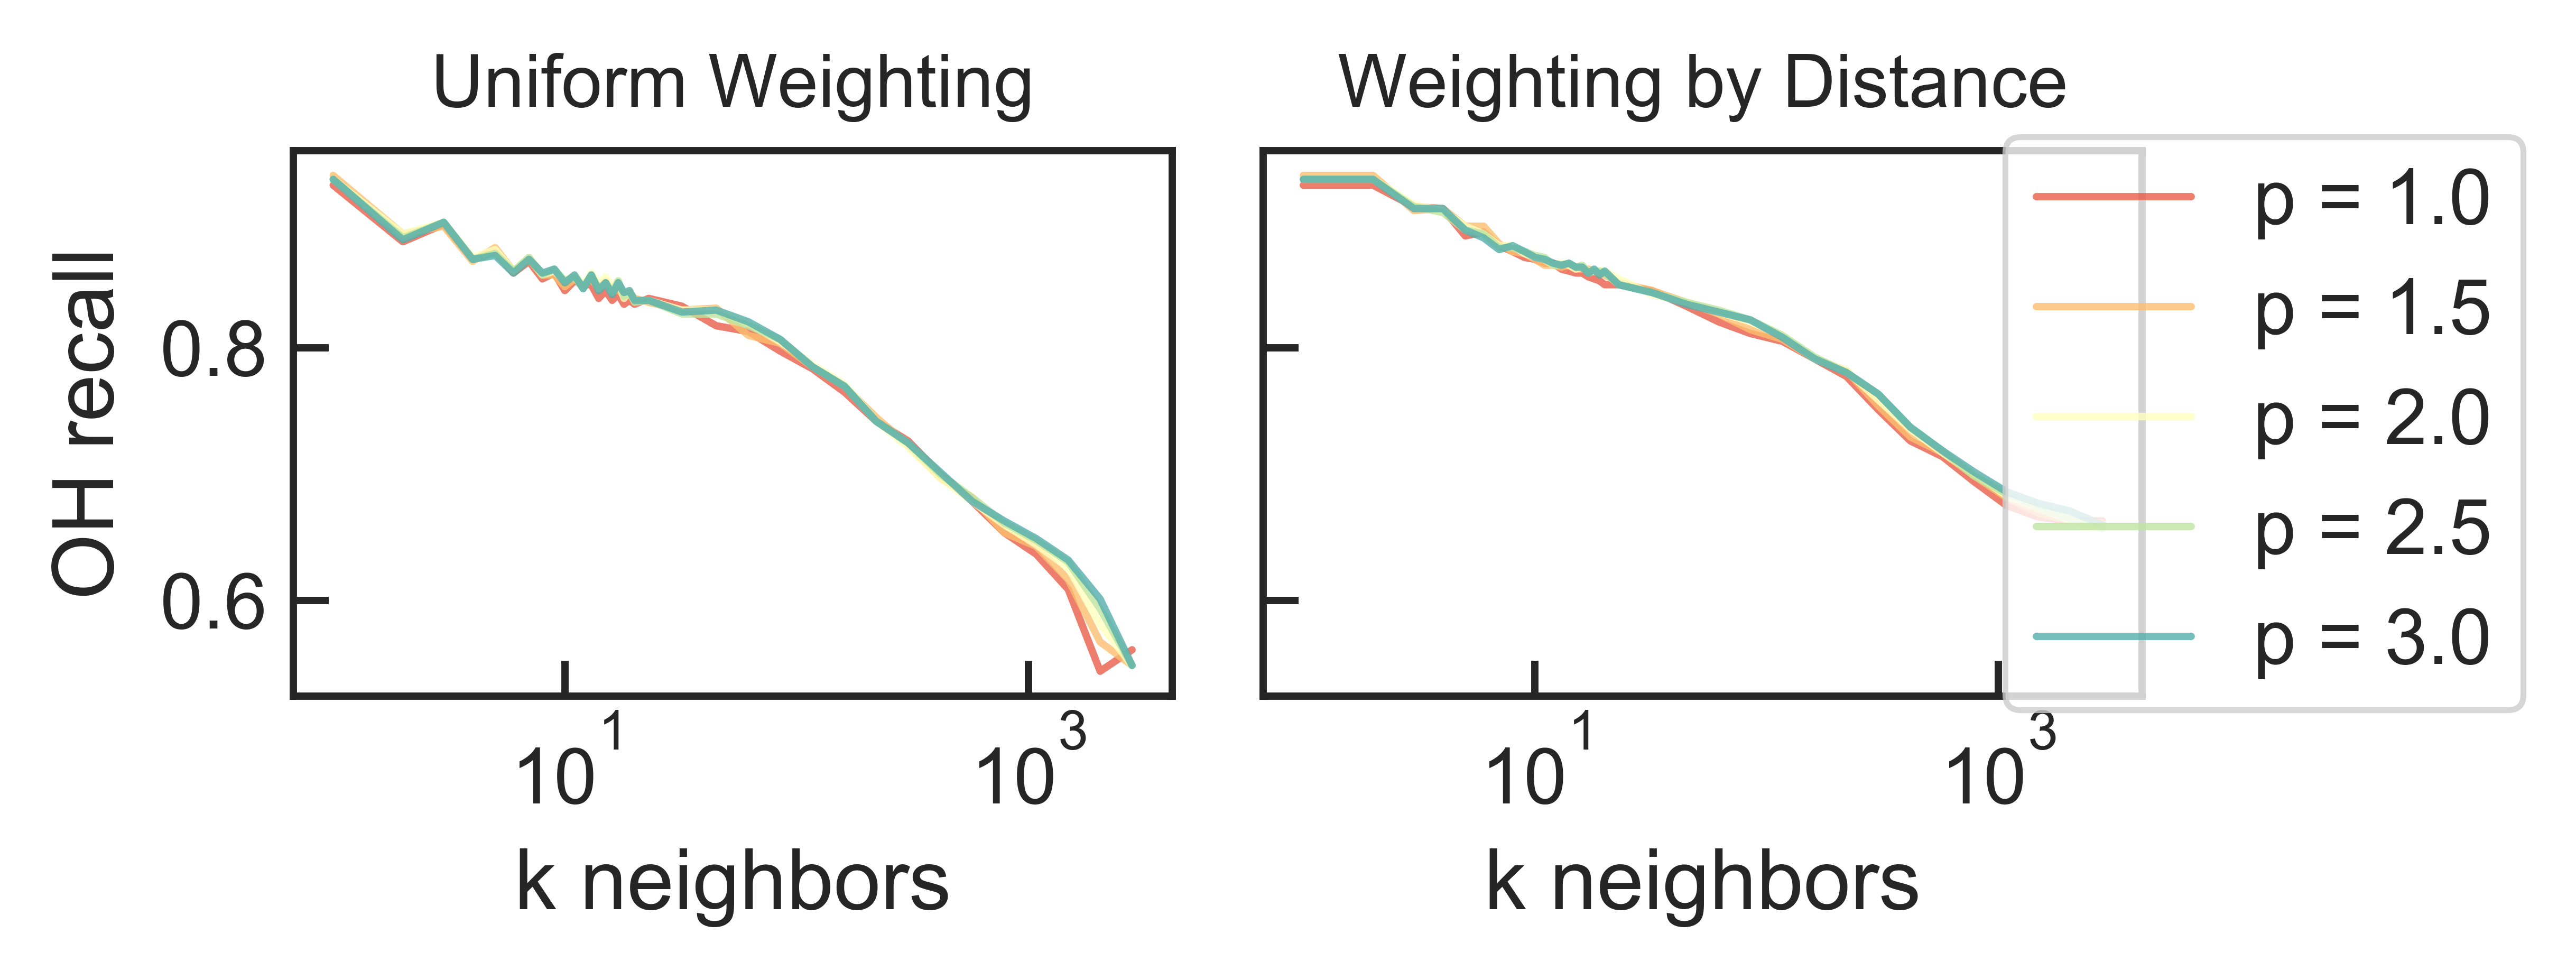

In [34]:
p_cols = sns.color_palette('Spectral', 5)
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, dpi = 1000, figsize = (5,2), sharey = True)
for i,p in enumerate(ps):
#     if p in [1.0,2.0,3.0]:
    ax1.plot(ns, recalls_uniform_w12z.loc[:,p], color = p_cols[i], label = 'p = ' + str(p), alpha = 0.8, linewidth=1)
    ax2.plot(ns, recalls_w12z.loc[:,p], color = p_cols[i], label = 'p = ' + str(p), alpha = 0.8, linewidth=1)
ax1.set_xlabel('k neighbors')
ax2.set_xlabel('k neighbors')
ax1.set_ylabel('OH recall')
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_title('Uniform Weighting', size = 10)
ax2.set_title('Weighting by Distance', size = 10)
ax2.legend(loc='center left', bbox_to_anchor=(0.8, 0.5))
plt.tight_layout()
plt.savefig('Plots/kNN_optimization.pdf')
plt.show()

In [36]:
print('For p = 2, the max is:', round(np.max(recalls_w12z[2.0][:20]),3))
print('Which corresponds to k neighbors of', recalls_w12z[2.0][:20].idxmax())

For p = 2, the max is: 0.934
Which corresponds to k neighbors of 1


In [38]:
print('For p = 3, the max is:', round(np.max(recalls_w12z[3.0][:20]),3))
print('Which corresponds to k neighbors of', recalls_w12z[3.0][:20].idxmax())

For p = 3, the max is: 0.934
Which corresponds to k neighbors of 1


In [39]:
print('For p = 2.5, the max is:', round(np.max(recalls_w12z[2.5][:20]),3))
print('Which corresponds to k neighbors of', recalls_w12z[2.5][:20].idxmax())

For p = 2.5, the max is: 0.934
Which corresponds to k neighbors of 1


### Parameters: p=2, k=4

In [37]:
knn = KNeighborsClassifier(n_neighbors=1, p=2, weights = 'distance')
knn.fit(X_train, y_train)
pred = knn.predict(X_test)
prob = knn.predict_proba(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

          HI       0.93      0.96      0.94       594
          OH       0.96      0.93      0.95       647

    accuracy                           0.94      1241
   macro avg       0.94      0.94      0.94      1241
weighted avg       0.94      0.94      0.94      1241



In [41]:
classification_report(y_test, pred, output_dict = True)['OH']['recall']

0.9088098918083463

In [42]:
classification_report(y_test, pred, output_dict = True)['OH']['precision']

0.9882352941176471

In [43]:
pred_OH = (pred == 'OH')
pred_HI = (pred == 'HI')

OH_TP = pred_OH & (y_test=='OH')
OH_FP = pred_OH & (y_test=='HI')
HI_TP = pred_HI & (y_test=='HI')
OH_FN = pred_HI & (y_test=='OH')

In [44]:
X_test = scaler.inverse_transform(X_test) 

In [44]:
# fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharey = True, dpi = 300, figsize = (5,3))
# ax1.scatter(X_test[:,1][pred_HI], X_test[:,0][pred_HI], c = 'white', s=1, alpha=0.5, label = 'HI')
# ax1.scatter(X_test[:,1][pred_OH], X_test[:,0][pred_OH], c = prb, s=1, alpha=0.5, label = 'OH')
# ax1.set_xlabel('W1-W2')
# ax1.set_ylabel('W1')
# ax1.set_title('Predictions')
# ax1.legend(loc = 'lower right')

# ax2.scatter(X_test[:,1][HI_TP | OH_TP], X_test[:,0][HI_TP | OH_TP], s=2, alpha=0.2, label = 'OH + HI TP', zorder = 1, c = 'grey', marker = '.')
# ax2.scatter(X_test[:,1][OH_FN], X_test[:,0][OH_FN], s=5, alpha=0.6, label = 'OH FN', zorder = 10, c = 'white', marker = 'o')
# ax2.scatter(X_test[:,1][OH_FP], X_test[:,0][OH_FP], s=5, alpha=0.6, label = 'OH FP', zorder = 10, c = prb, marker = 'o')
# ax2.set_xlabel('W1-W2')
# ax2.set_title('Comparison to Actual')
# ax2.legend(loc = 'lower right')

# # plt.title('ML with W1, W1-W2, $z_{HI}$')
# plt.show()

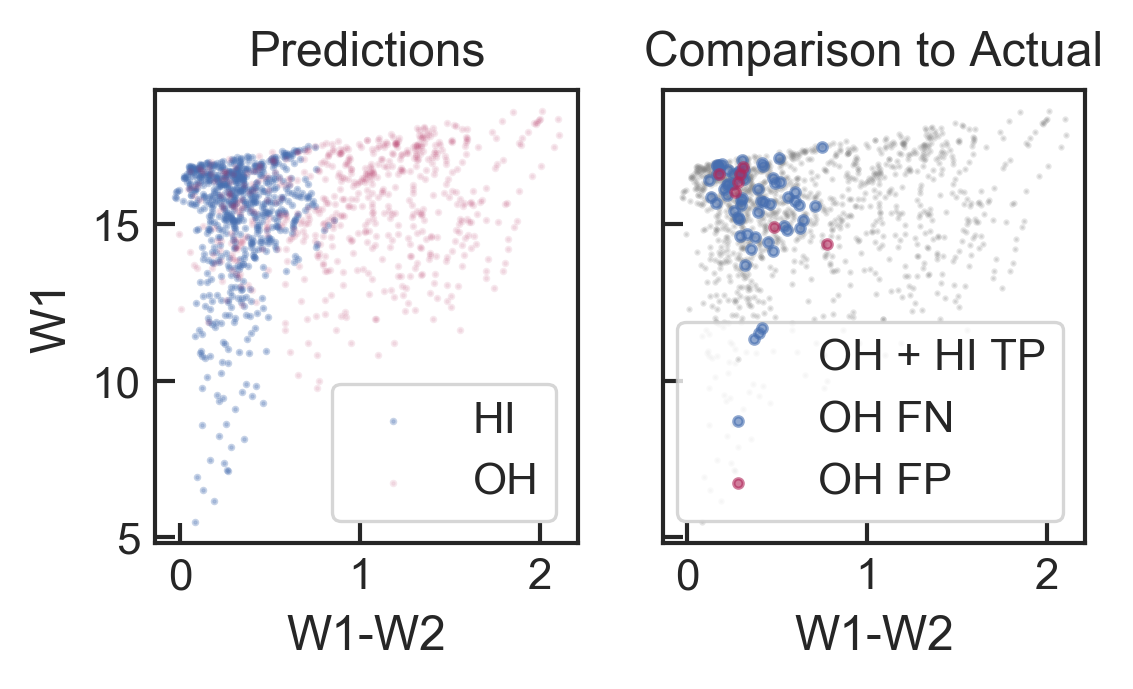

In [45]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, sharey = True, dpi = 300, figsize = (4,2))
ax1.scatter(X_test[:,1][pred_HI], X_test[:,0][pred_HI], c = '#466eb0', s=1, alpha=0.3, label = 'HI')
ax1.scatter(X_test[:,1][pred_OH], X_test[:,0][pred_OH], c = '#b1285b', s=1, alpha=0.1, label = 'OH')
ax1.set_xlabel('W1-W2')
ax1.set_ylabel('W1')
ax1.set_title('Predictions')
ax1.legend(loc = 'lower right')

ax2.scatter(X_test[:,1][HI_TP | OH_TP], X_test[:,0][HI_TP | OH_TP], s=2, alpha=0.2, label = 'OH + HI TP', zorder = 1, c = 'grey', marker = '.')
ax2.scatter(X_test[:,1][OH_FN], X_test[:,0][OH_FN], s=5, alpha=0.6, label = 'OH FN', zorder = 10, c = '#466eb0', marker = 'o')
ax2.scatter(X_test[:,1][OH_FP], X_test[:,0][OH_FP], s=5, alpha=0.6, label = 'OH FP', zorder = 10, c = '#b1285b', marker = 'o')
ax2.set_xlabel('W1-W2')
ax2.set_title('Comparison to Actual')
ax2.legend(loc = 'lower right')

# plt.title('ML with W1, W1-W2, $z_{HI}$')
plt.show()

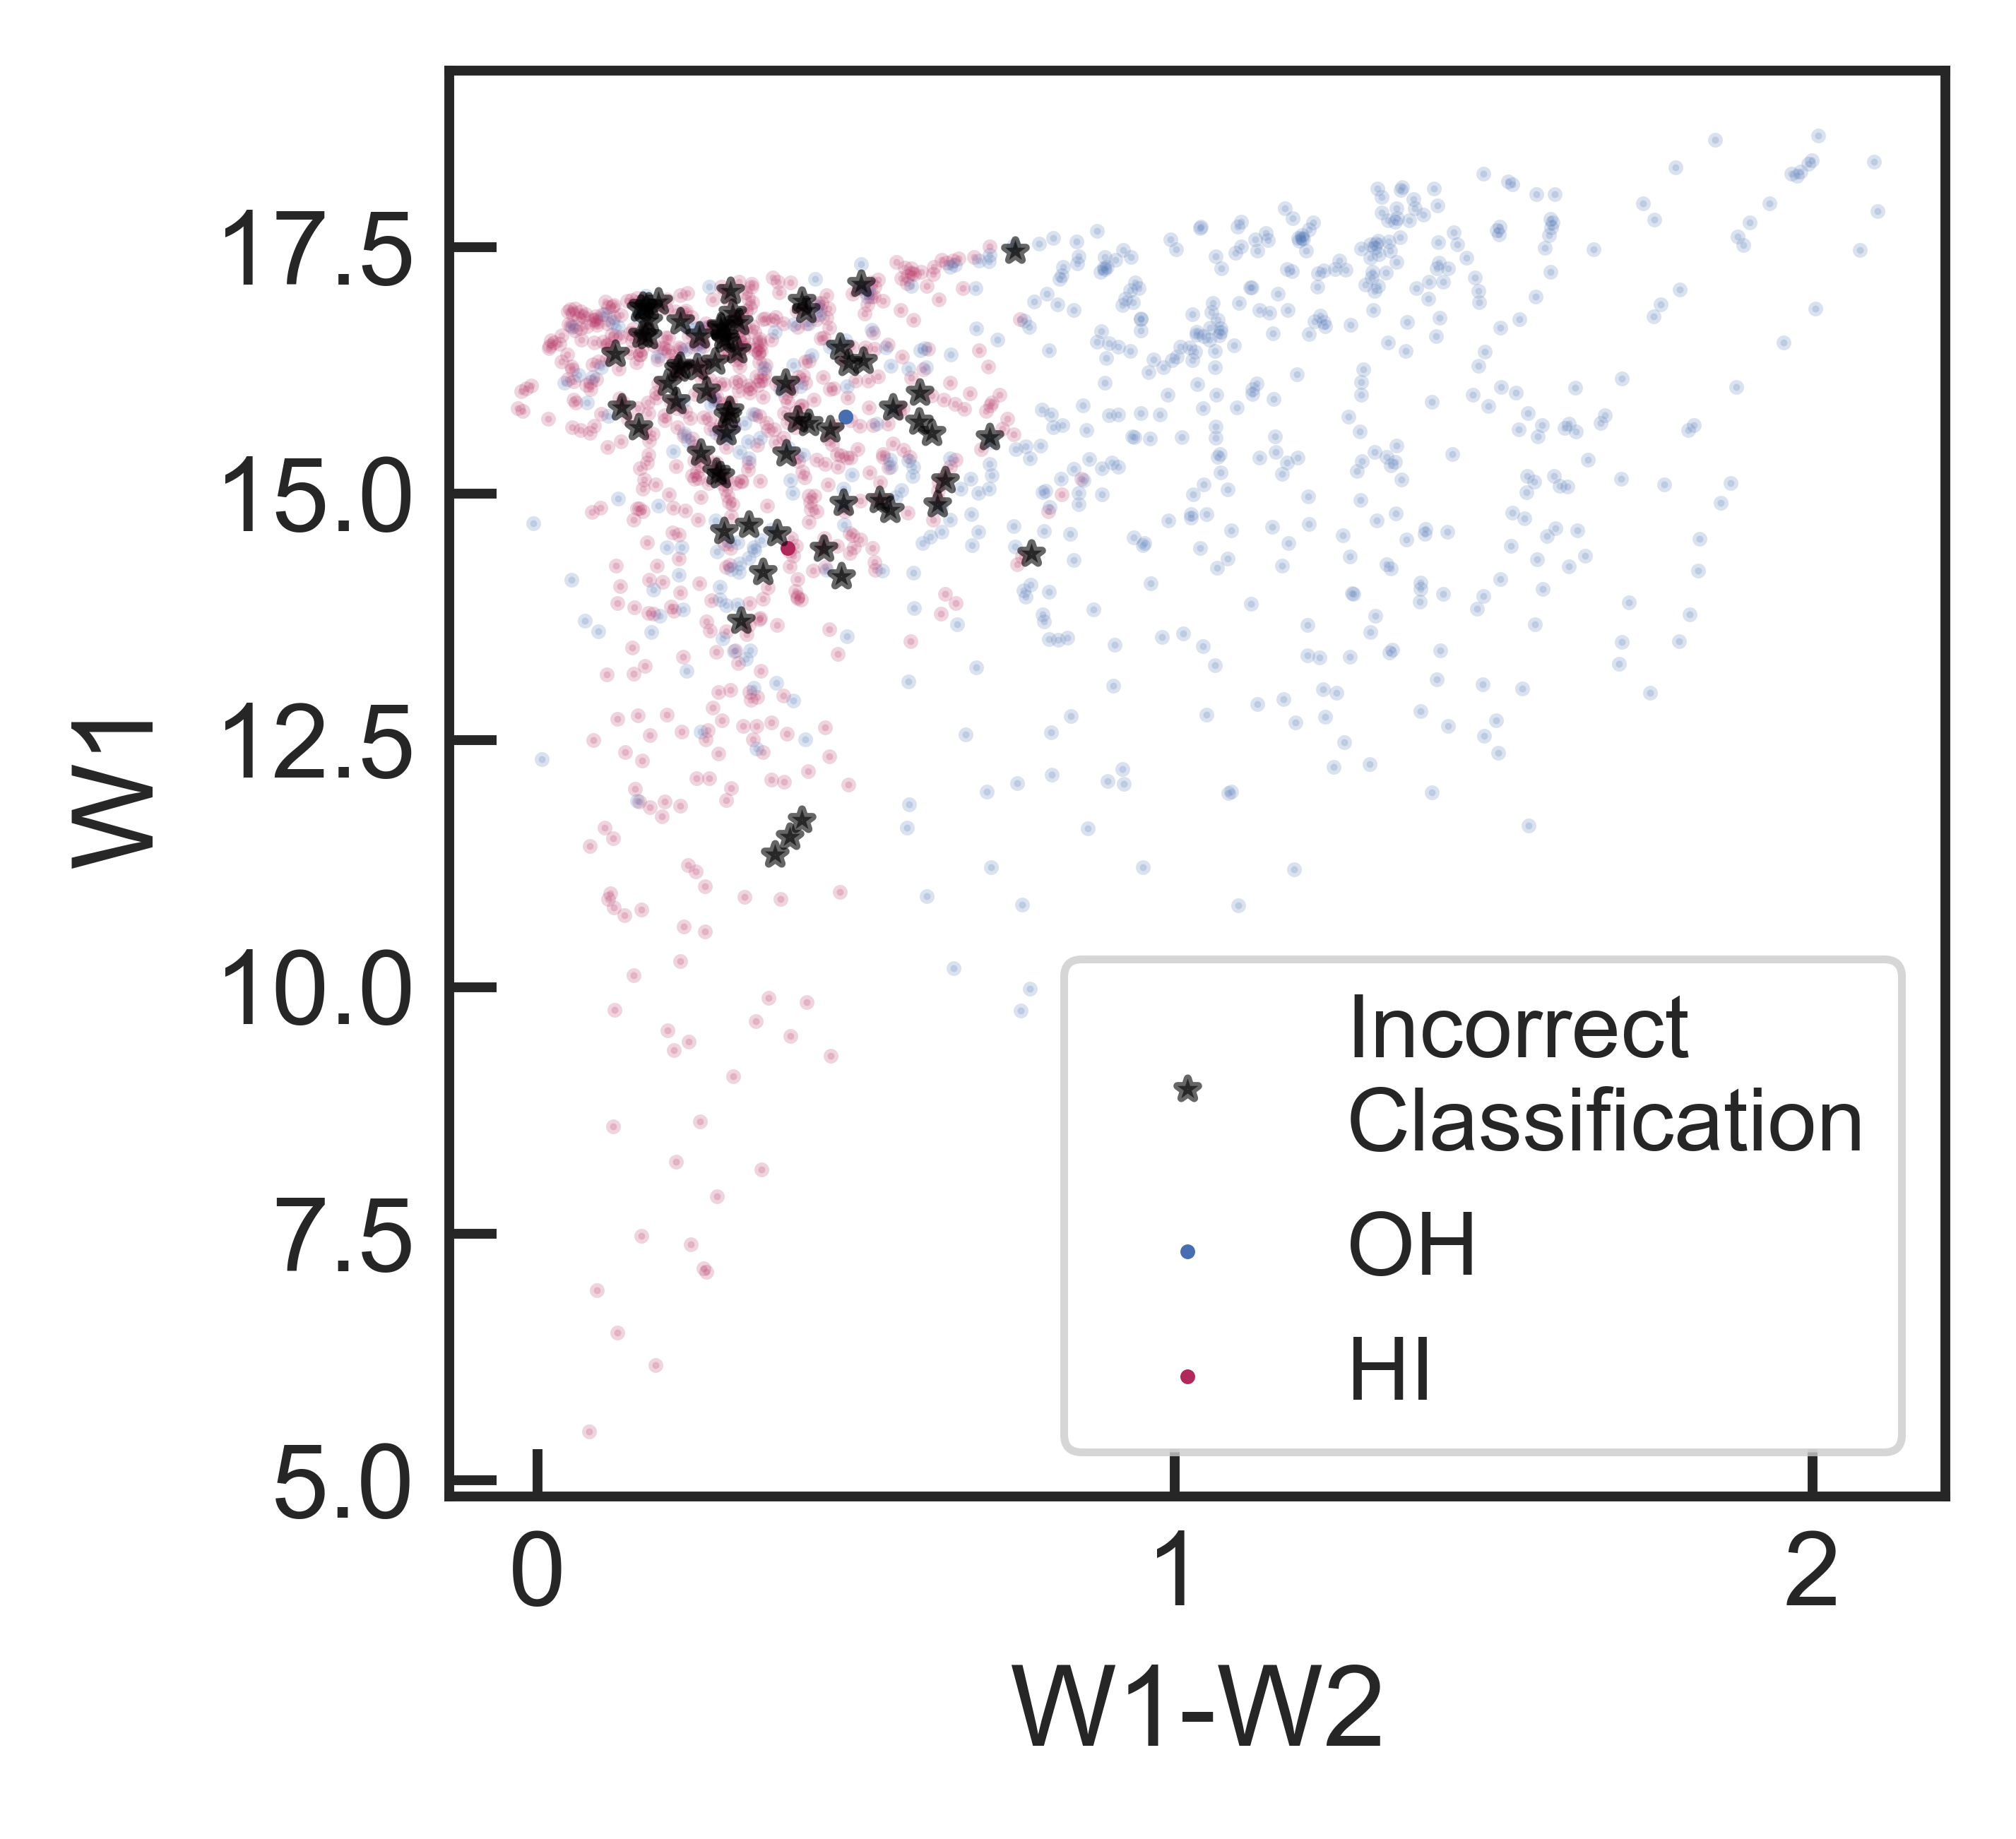

In [46]:
fig, ax2 = plt.subplots(dpi = 1000, figsize = (3,2.75))
# ax1.scatter(X_test[:,1][pred_HI], X_test[:,0][pred_HI], c = '#466eb0', s=1, alpha=0.3, label = 'HI')
# ax1.scatter(X_test[:,1][pred_OH], X_test[:,0][pred_OH], c = '#b1285b', s=1, alpha=0.1, label = 'OH')
# ax1.set_xlabel('W1-W2')
# ax1.set_ylabel('W1')
# ax1.set_title('Predictions')
# ax1.legend(loc = 'lower right')
# ax2.scatter(X_train[:,1][y_train == 'HI'], X_train[:,0][y_train == 'HI'], s=2, alpha=0.1, zorder = 1, c = '#b1285b', marker = '.')
ax2.scatter(X_test[:,1][HI_TP], X_test[:,0][HI_TP], s=2, alpha=0.2, zorder = 1, c = '#b1285b', marker = '.')
# ax2.scatter(X_train[:,1][y_train == 'OH'], X_train[:,0][y_train == 'OH'], s=2, alpha=0.1, zorder = 1, c = '#466eb0', marker = '.')
ax2.scatter(X_test[:,1][OH_TP], X_test[:,0][OH_TP], s=2, alpha=0.2, zorder = 1, c = '#466eb0', marker = '.')
ax2.scatter(X_test[:,1][OH_FN], X_test[:,0][OH_FN], s=5, alpha=0.6, zorder = 10, c = 'k', marker = '*')
ax2.scatter(X_test[:,1][OH_FP], X_test[:,0][OH_FP], s=5, alpha=0.6, label = 'Incorrect\nClassification', zorder = 10, c = 'k', marker = '*')
ax2.set_xlabel('W1-W2')
ax2.set_ylabel('W1')
# ax2.set_title('Comparison to Actual')
ax2.scatter(X_test[:,1][OH_TP][0], X_test[:,0][OH_TP][0], s=2, label = 'OH', zorder = 1, c = '#466eb0', marker = '.')
ax2.scatter(X_test[:,1][HI_TP][0], X_test[:,0][HI_TP][0], s=2, label = 'HI', zorder = 1, c = '#b1285b', marker = '.')
ax2.legend(loc = 'lower right', prop = {'size':9})

# plt.title('ML with W1, W1-W2, $z_{HI}$')
plt.tight_layout()
plt.show()

In [47]:
print("Number correctly identified:", len(X_test[HI_TP | OH_TP]))
print("Number incorrectly identified:", len(X_test[OH_FP | OH_FN]))
print("Fraction that are incorrect:", len(X_test[OH_FP | OH_FN])/len(X_test[HI_TP | OH_TP]))

Number correctly identified: 1175
Number incorrectly identified: 66
Fraction that are incorrect: 0.05617021276595745


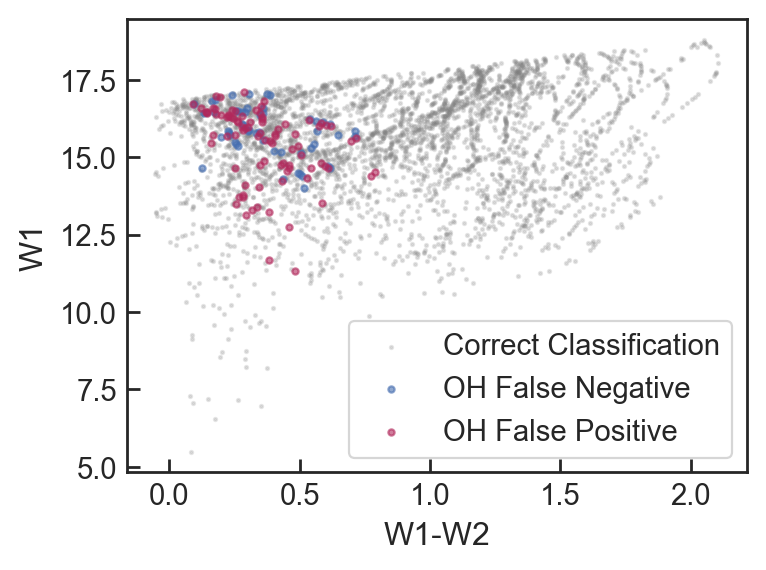

In [48]:
# fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 2, sharey = True, dpi = 300, figsize = (4,2))
plt.figure(figsize = (4,3))
plt.scatter(X_test[:,1][HI_TP | OH_TP], X_test[:,0][HI_TP | OH_TP], s=5, alpha=0.2, label = 'Correct Classification', zorder = 1, c = 'grey', marker = '.')
plt.scatter(X_test[:,1][OH_FN], X_test[:,0][OH_FN], s=5, alpha=0.6, label = 'OH False Negative', zorder = 10, c = '#466eb0', marker = 'o')
plt.scatter(X_test[:,1][OH_FP], X_test[:,0][OH_FP], s=5, alpha=0.6, label = 'OH False Positive', zorder = 10, c = '#b1285b', marker = 'o')
plt.xlabel('W1-W2')
plt.ylabel('W1')
plt.legend(loc = 'lower right')

# plt.title('ML with W1, W1-W2, $z_{HI}$')
plt.show()